### Détails des étapes :
1. **Critères et création des points d'objet** :
   - Les critères définissent quand l'algorithme de détection des coins s'arrête.
   - `objp` représente les points d'un échiquier dans le monde réel, avec z=0.

2. **Détection des coins dans les images** :
   - Conversion des images en niveaux de gris pour faciliter la détection des coins.
   - Détection des coins pour chaque image et stockage des points 2D/3D.

3. **Calibration de la caméra** :
   - Calcul des matrices intrinsèques (`mtx`) et des vecteurs de rotation/translation (`rvecs`, `tvecs`).

4. **Calcul des matrices de rotation et translation** :
   - Les vecteurs de rotation sont convertis en matrices.
   - Les matrices de rotation sont étendues avec les vecteurs de translation pour former des matrices 3x4.

5. **Projection et position des caméras** :
   - Les matrices de projection (3x4) combinent les paramètres intrinsèques et extrinsèques.
   - Les centres des caméras sont calculés dans le référentiel monde via des coordonnées homogènes.

Ce format garde le code clair et précise chaque étape clé sans surcharger d'informations inutiles.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob

# Critères d'arrêt pour l'algorithme de détection des coins de l'échiquier
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Création des points d'objet 3D pour un échiquier de 7x7 intersections
objp = np.zeros((7*7, 3), np.float32)  # Initialisation d'un tableau de points (z=0 par défaut)
objp[:, :2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)  # Coordonnées x, y de la grille d'intersections

print(objp)

# Listes pour stocker les points 3D (réels) et les points 2D (dans l'image)
objpoints = []  # Points 3D
imgpoints = []  # Points 2D

# Parcours des images d'échiquier correspondantes
for fname in glob.glob('chessboards/c4*.png'):
    img = cv.imread(fname)  # Chargement de l'image
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Conversion de l'image en niveaux de gris
    ret, corners = cv.findChessboardCorners(gray, (7, 7), None)  # Détection des coins de l'échiquier
    if ret:
        objpoints.append(objp)  # Ajout des points 3D correspondants
        imgpoints.append(corners)  # Ajout des coins détectés (points 2D)

# Calibration de la caméra avec les points correspondants 2D et 3D
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# ret : Booléen indiquant si la calibration a réussi
# mtx : Matrice intrinsèque de la caméra
# dist : Coefficients de distorsion (non utilisés ici)
# rvecs, tvecs : Vecteurs de rotation et translation pour chaque image

# Conversion des vecteurs de rotation en matrices de rotation
rmatRight = cv.Rodrigues(rvecs[0])[0]  # Matrice de rotation pour la caméra droite
rmatLeft = cv.Rodrigues(rvecs[1])[0]   # Matrice de rotation pour la caméra gauche

# Ajout des vecteurs de translation pour obtenir des matrices 3x4
rotMatRight = np.concatenate((rmatRight, tvecs[0]), axis=1)
rotMatLeft = np.concatenate((rmatLeft, tvecs[1]), axis=1)

# Matrices de projection des caméras (intrinsèque * rotation-translation)
camLeft = mtx @ rotMatLeft
camRight = mtx @ rotMatRight

# Calcul des centres des caméras dans le référentiel monde (coordonnées homogènes 4x1)
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft, [[0, 0, 0, 1]]), axis=0)) @ np.transpose([[0, 0, 0, 1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight, [[0, 0, 0, 1]]), axis=0)) @ np.transpose([[0, 0, 0, 1]])


[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [6. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [6. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [6. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [6. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [0. 6. 0.]
 [1. 6. 0.]
 [2. 6. 0.]
 [3. 6. 0.]
 [4. 6. 0.]
 [5. 6. 0.]
 [6. 6. 0.]]


### Détails :
1. **Introduction de la fonction** : Explique son rôle global (visualisation de la position des caméras et des points 3D).
2. **Étapes principales** :
   - Création de la figure 3D et des axes.
   - Affichage des points de l'objet 3D.
   - Affichage des positions des caméras gauche et droite avec des couleurs distinctes.
3. **Appel de la fonction** : Indique que la scène est générée lorsqu'on appelle `plotDotWorld`.

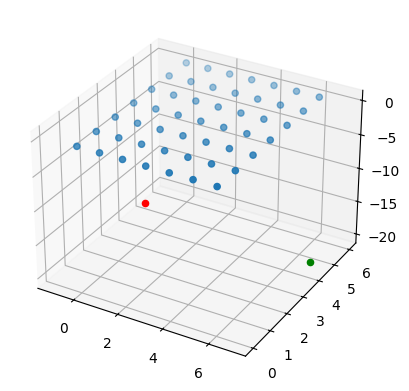

In [10]:
# Fonction pour visualiser dans l'espace 3D la position des caméras et de l'objet (jeu d'échecs)
def plotDotWorld():
    # Création d'une figure 3D
    fig = plt.figure()                                       # Crée une figure vide
    ax = plt.axes(projection='3d')                          # Ajoute des axes 3D pour une visualisation en trois dimensions
    
    # Affichage des points 3D de l'objet
    ax.scatter3D(objp[:, 0], objp[:, 1], objp[:, 2])         # Place les points de l'objet (objp) dans l'espace 3D
    
    # Affichage de la position de la caméra gauche
    x, y, z, d = camWorldCenterLeft                          # Coordonnées homogènes de la caméra gauche
    ax.scatter(x, y, z, c='g', marker='o')                   # Représente la caméra gauche par un point vert ('g')
    
    # Affichage de la position de la caméra droite
    x2, y2, z2, d2 = camWorldCenterRight                     # Coordonnées homogènes de la caméra droite
    ax.scatter(x2, y2, z2, c='r', marker='o')                # Représente la caméra droite par un point rouge ('r')
    
    # Affichage de la figure 3D
    plt.show()                                               # Affiche la figure

# Appel de la fonction pour afficher la scène 3D
plotDotWorld()
